In [1]:
%matplotlib inline

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Two versions of dust file

1. oh5_kappa includes opacity per gram of gas and wavelength in micron
2. sigma_oh5.ref includes absorption and scattering cross section per dust grain, anisotropy factor, and wavelength in micron

## Hyperion dust input:
  [nu, albedo, chi, g, p_lin_max]
  * nu ($\nu$): Frequency
  * albedo: $\sigma_{\rm scat}/(\sigma_{\rm scat}+\sigma_{\rm abs})$.  This quantity is dimensionless.
  * chi ($\chi_{\nu}$): The mass extinction coefficient, opacity per gram of dust.
  * g: The anisotropy scattering factor.
  * p_lin_max: something to do with polarization.  No polarization is assumed, therefore set to zero.

$$\rho_{\rm d} \kappa_{\rm d} = n_{\rm d}(\sigma_{\rm abs}+\sigma_{\rm scat})$$ 

$$\kappa_{\rm d} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{n_{\rm d}}{\rho_{\rm d}} = 100 \kappa_{\rm g}$$ 

$$\kappa_{\rm g} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{n_{\rm d}}{100\rho_{\rm d}} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{n_{\rm d}}{\rho_{\rm g}}$$ 

and by definition
$$\rho_{\rm g} = \mu m_{\rm H}n_{\rm g}, \quad \mu = 2.29$$
so that
$$\kappa_{\rm g} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{n_{\rm d}}{\mu m_{\rm H}n_{\rm g}}$$
$$\kappa_{\rm d} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{100n_{\rm d}}{\rho_{\rm g}} = (\sigma_{\rm abs}+\sigma_{\rm scat})\frac{100n_{\rm d}}{\mu m_{\rm H}n_{\rm g}}$$
with the communication with Neal
$$\frac{n_{\rm d}}{\mu n_{\rm g}} =  1.1015 \times 10^{-14}$$

Appaerently more complicate than that.  Adopting the ratio between two files from now on.
$$\frac{\kappa_{\rm g}}{\sigma_{\rm d}} = 1.039 \times 10^{12}$$

$$\frac{\kappa_{\rm d}}{\sigma_{\rm d}} = 1.039 \times 10^{14}$$

In [9]:
import astropy.constants as const
c = const.c.cgs.value
mh = const.m_p.cgs.value + const.m_e.cgs.value

import numpy as np
oh5_kappa = np.genfromtxt('/Users/yaolun/Google Drive/dust_model/Dust_OH5_Evans_Shirley/OH/oh5.kappa', 
                          skip_header=1).T 
# This is opacity per gram of gas
oh5_sigma = np.genfromtxt('/Users/yaolun/Google Drive/dust_model/Dust_OH5_Evans_Shirley/sigma.oh5.ref', 
                          skip_header=2, skip_footer=1).T
# This one has absorption and scattering cross section and g value with wavelength 

factor = 1

# oh5_sigma has more wavelength channels

nu = c/oh5_sigma[3,:]*1e4
# nu = oh5_sigma[3,:]
albedo = oh5_sigma[1,:]/(oh5_sigma[0,:]+oh5_sigma[1,:])
chi = (oh5_sigma[0,:]+oh5_sigma[1,:]) * 1.0395087779657002e14
g = oh5_sigma[2,:]

# sort by frequency
ind = np.argsort(nu)
nu = nu[ind]
albedo = albedo[ind]
chi = chi[ind]
g = g[ind]

foo = open('/Users/yaolun/Google Drive/dust_model/Dust_OH5_Evans_Shirley/oh5_hyperion.txt','w')
for i in range(0, len(nu)):
#     if c/nu[i]*1e4 >= 70:
#         factor = 0.75
    foo.write('%e \t %e \t %e \t %e \n' % (nu[i],albedo[i],chi[i],g[i]))
foo.close()


# Test out Ormel et al. 2009 model

In [47]:
def opac_file(age_ind, model='(ic-sil,ic-gra)'):
    from astropy.io import ascii
    # read in Ormel et al. 2011
    dust_ormel = ascii.read('/Users/yaolun/Copy/dust_model/Ormel2011/'+model+str(age_ind)+'opc.txt',\
                            header_start=None, names=['lambda','kappa-ext','kappa-sca','kappa-back','gsca'])
    return dust_ormel, model+str(age_ind)+'opc'

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.constants as const
c = const.c.cgs.value

# read in Ormel et al. 2011
# the table is in cm2/unit gram of dust
# dust_ormel_1my = opac_file(4)
# dust_ormel_03my = opac_file(3)

In [25]:
# read in OH5_extended dust model
dust_oh5 = ascii.read('/Users/yaolun/Copy/dust_model/Dust_OH5_Evans_Shirley/oh5_hyperion.txt', header_start=None, names=['nu','albedo','chi','g'])

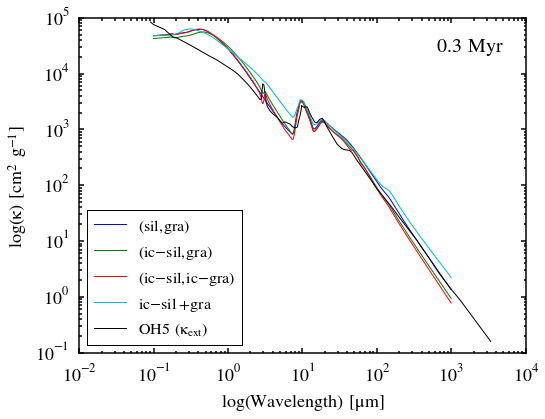

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
time_label = [r'$\rm{30\,kyr}$',r'$\rm{0.1\,Myr}$',r'$\rm{0.3\,Myr}$',r'$\rm{1\,Myr}$',r'$\rm{3\,Myr}$',r'$\rm{10\,Myr}$']
time = 3
for mod in ['(sil,gra)','(ic-sil,gra)','(ic-sil,ic-gra)','ic-sil+gra']:
    ormel_dum, modelname_dum = opac_file(time, model=mod)
    ax.plot(ormel_dum['lambda']*1e4, ormel_dum['kappa-ext'],'-', label=r'$\rm{'+mod+'}$')
# ax.plot(dust_ormel_03my['lambda']*1e4, dust_ormel_03my['kappa-ext'],'-', color='k', label=r'$\rm{O09-0.3Myr\,(\kappa_{ext})}$')
# ax.plot(dust_ormel['lambda']*1e4, dust_ormel['kappa-sca'],'--', color='b', label=r'$\rm{O09\,(\kappa_{sca})}$')
ax.plot(c/dust_oh5['nu']*1e4, dust_oh5['chi'], '-', color='k', label=r'$\rm{OH5\,(\kappa_{ext})}$')
# ax.plot(c/dust_oh5['nu']*1e4, dust_oh5['albedo'])
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='lower left', numpoints=1,fontsize=16)
ax.text(0.8,0.9, time_label[time-1], transform=ax.transAxes, fontsize=20)

ax.set_xlabel(r'$\rm{log(Wavelength)\,[\mu m]}$', fontsize=18)
ax.set_ylabel(r'$\rm{log(\kappa)\,[cm^{2}\,g^{-1}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

## Output the Ormel dust model to Hyperion dust format

In [60]:
import os
outdir = '/Users/yaolun/Copy/dust_model/Ormel2011/hyperion/'
time = 2
for mod in ['(sil,gra)','(ic-sil,gra)','(ic-sil,ic-gra)','ic-sil+gra']:
    ormel_dum, modelname_dum = opac_file(time, model=mod)
    foo = open(outdir+modelname_dum+'.txt', 'w')
    for i in range(len(ormel_dum['lambda'])-1,0, -1):
        foo.write('%e \t %e \t %e \t %e \n' % \
            (c/ormel_dum['lambda'][i], ormel_dum['kappa-sca'][i]/ormel_dum['kappa-ext'][i], ormel_dum['kappa-ext'][i], ormel_dum['gsca'][i]))
    foo.close()